# 7. Rotace galaxie
## Zadání


Rozložení zářivé hmoty v naší galaxii je dáno vztahem:


$$ \rho(x,y,z) = \rho_b \exp \left( - \frac{x^2 + y^2}{r_b^2} \right) \exp \left( - \frac{z^2}{z_b^2} \right) + \rho_d \exp \left( - \frac{\sqrt{x^2 + y^2}}{r_d} \right) \exp \left( - \frac{z}{z_d} \right),$$

kde galaktická výduť má parametry $\rho_b = 15 \, M_{\odot} \, \mathrm{pc}^{-3}$, $r_b = 0.6 \, \mathrm{kpc}$, $z_b = 0.37 \, \mathrm{kpc}$ a galaktický disk $\rho_d = 2.7 \, M_{\odot} \, \mathrm{pc}^{-3}$, $r_d = 2.3 \, \mathrm{kpc}$, $z_d = 0.32 \, \mathrm{kpc}$. Řešením Poissonovy rovnice

$$ \nabla^2 \varphi(\textbf{r}) = 4 \pi G \rho(\textbf{r})$$

pro grav. potenciál nalezněte gravitační pole galaxie a určete rychlost otáčení jednotlivých částí. Při řešení použijte diskrétní Fourierovu transformaci a periodické okrajové podmínky. Dlouhovlnou singulritu je třeba vhodně ošetřit.

## Řešení

Hustotu $\rho(\textbf{r})$ si vyjádříme jako zpětnou Fourierovu transfrormaci z dopředné transformace

$$ \rho(\textbf{r}) = \frac{1}{(2 \pi)^{3/2}} \int \rho^{\mathrm{FT}} (\textbf{k}) \mathrm{e}^{i \textbf{k} \cdot \textbf{r}} \mathrm{d}^3 \textbf{k}.$$

a tento výraz dosadíme do Poissonovy rovnice pro gravitační potenciál

$$ \nabla^2 \varphi(\textbf{r}) = 4 \pi G \frac{1}{(2 \pi)^{3/2}} \int \rho^{\mathrm{FT}} (\textbf{k}) \mathrm{e}^{i \textbf{k} \cdot \textbf{r}} \mathrm{d}^3 \textbf{k}.$$

Operátor $\nabla^2$ je vlastně jen druhá derivace podle polohy $\frac{d^2}{d\textbf{r}^2}$ a protože $\rho^{\mathrm{FT}}(\textbf{k})$ není funkcí $\textbf{r}$ můžeme rovnici jednoduše zintegrovat

$$ \varphi(\textbf{r}) = 4 \pi G \frac{1}{(2 \pi)^{3/2}} \int \rho^{\mathrm{FT}}(\textbf{k}) \frac{e^{i \textbf{k} \cdot \textbf{r}}}{-k^2}\mathrm{d}^3 \textbf{k}.$$

<br />

dvě možnosti výpočtu $k$:

### a) při zpětné FT podělím spektrum $k^2$,

kde $k$ = sqrt(min(i, N-i)$^2$ + min(j, N-j)$^2$ + min(k, N-k)$^2$)

<!-- hodnotu $k$ ve 3D jsem odhadnul pomocí vašeho řešení ve fourier_CAT.py, ale asi to nebude úplně správně -->

<br />

### b) při zpětné FT podělím spektrum vlastními hodnotami Laplacova operátoru: 

takže vlastně jakoby $k^2 = 4 \cdot \left[ sin^2 \left( \frac{\pi i}{N} \right) + sin^2 \left( \frac{\pi j}{N} \right) + sin^2 \left( \frac{\pi k}{N} \right) \right]$

postup podle https://algowiki-project.org/en/Poisson_equation,_solving_with_DFT

<br />

Výslednou rychlost následně spočteme z rovnosti odstředivé a gravitační síly $F_{od} = F_g$:

$$ m \frac{v^2}{r} = m \frac{\mathrm{d} \varphi}{\mathrm{d} r} $$

$$v = \sqrt{r \frac{\mathrm{d} \varphi}{\mathrm{d} r}} .$$

V Pythonu to bude vypadat následovně:

<!-- potential $\equiv \mathrm{pot}$<br /> -->
<!-- density $\equiv \mathrm{rho}$ -->

$$ \mathrm{pot} = 4 \pi G \cdot \mathrm{ifftn} \left( \frac{1}{k^2} \cdot \mathrm{fftn}({\mathrm{rho}}) \right)$$

$$ \mathrm{v} = \mathrm{sqrt} \left( \mathrm{r} \cdot \frac{\mathrm{diff}(\mathrm{pot})}{\mathrm{diff(\mathrm{r})}} \right) $$

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm, LogNorm, SymLogNorm
import numpy as np
from scipy.fftpack import fftn, ifftn
from astropy.constants import M_sun, pc, G

import warnings
warnings.filterwarnings('ignore')

plt.rc("font", size=13)

In [2]:
#G = 4.302 * 1e-3  #p c / Ms * (km/s)**2
kpc = pc.value * 1e3

# bulge
rho_b = 15  # Ms / pc3
r_b = 0.6  # kpc
z_b = 0.37  # kpc

# disk
rho_d = 2.7 # Ms / pc3
r_d = 2.3  # kpc
z_d = 0.32  # kpc

# vytvoření gridu
size = 100
N = 301
N2 = int(N/2)
R = np.linspace(-size, size, N)
z, y, x = np.meshgrid(R, R, R)

# výpočet hustoty
rho_bulge = rho_b * np.exp(-(x**2+y**2)/r_b**2) * np.exp(-z**2/z_b**2)
rho_disk = rho_d * np.exp(-((x**2+y**2)**(1/2))/r_d) * np.exp(-abs(z)/z_d)
rho = (rho_bulge + rho_disk) * M_sun.value / pc.value**3

# parametr tlumící gravitační zákon
a = 10 * kpc
#a = np.inf

# výpočet gridu vlastních hodnot
L = size * 2 * kpc
k = np.linspace(0, N-1, N) * np.pi / N
kx, ky, kz = np.meshgrid(k, k, k)
K = (np.sin(kx)**2 + np.sin(ky)**2 + np.sin(kz)**2) * (2 * np.pi / L)**2 * (N2)**2 / 2 #+ (1/a)**2
# ošetření singularity
K[np.where(K == 0)] = 1

k2 = [min(i, N-i) for i in range(N)]
kx2, ky2, kz2 = np.meshgrid(k2, k2, k2)
K2 = (kx2**2 + ky2**2 + kz2**2) * (2 * np.pi / L)**2 #+ (1/a)**2
K2[np.where(K2 == 0)] = 1

# dopředná FFT -> podělení vlastními hodnotami -> zpětná FFT
c = 4 * np.pi * G.value
pot = ifftn(-fftn(rho)/K) * c
pot2 = ifftn(-fftn(rho)/K2) * c
pot -= pot[0][0][0]
pot2 -= pot2[0][0][0]

# výpočet rychlosti
dpot_dr = np.diff(pot[N2:, N2, N2]) / np.diff(R[N2:] * kpc)
dpot_dr2 = np.diff(pot2[N2:, N2, N2]) / np.diff(R[N2:] * kpc)
r = (R[N2:-1] + R[N2+1:]) / 2 * kpc
v = np.sqrt(r * dpot_dr) / 1e3
v2 = np.sqrt(r * dpot_dr2) / 1e3

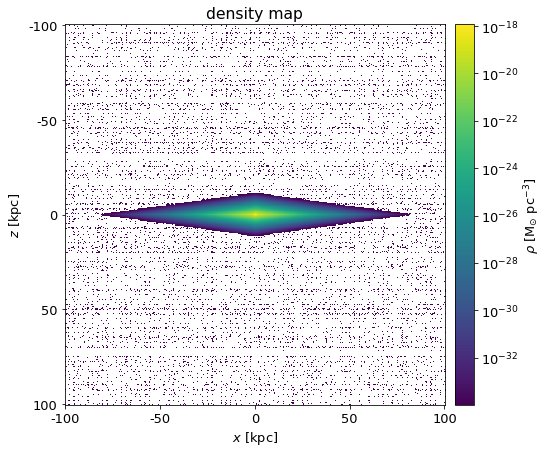

In [3]:
x1 = np.linspace(0, N-1, 5)
x1_l = np.linspace(-size, size, 5)
x_l = []
for i in range(len(x1_l)): x_l.append("{0:d}".format(int(x1_l[i])))

fig, ax1 = plt.subplots(1, 1, figsize=(9,7))
ax1.set_title("density map")
im1 = ax1.imshow(np.where(rho[N2,:,:] > 1e-34, rho[N2,:,:], 0), norm=LogNorm())
ax1.set_xticks(x1)
ax1.set_xticklabels(x_l)
ax1.set_yticks(x1)
ax1.set_yticklabels(x_l)
ax1.set_xlabel("$x$ [kpc]")
ax1.set_ylabel("$z$ [kpc]")
#ax1.ticklabel_format(axis='both', style='plain')
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.02)
cbar1.set_label("$\\rho$ [M$_{\odot}$ pc$^{-3}$]")

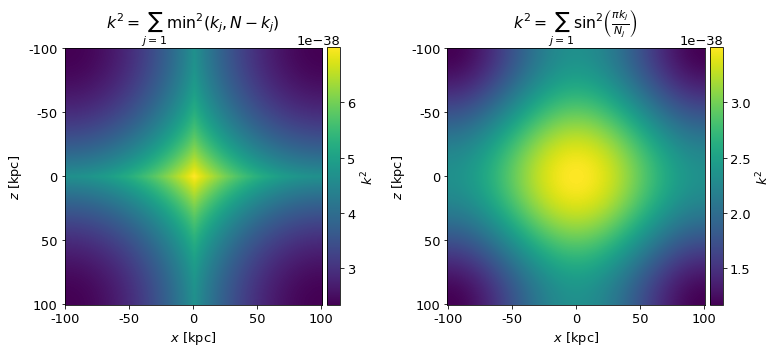

In [4]:
pad = 0.02
frac = 0.05
figsize = (11,5)
fig, ax1 = plt.subplots(1, 2, figsize=figsize)
ax1[0].set_title("$k^2 = \sum_{j=1} \mathrm{min}^2(k_j, N-k_j)$")
im1 = ax1[0].imshow(K2[N2], norm=PowerNorm(1))
cbar1 = fig.colorbar(im1, ax=ax1[0], fraction=frac-0.00325, pad=pad)
cbar1.set_label("$k^2$")
ax1[0].set_xticks(x1)
ax1[0].set_xticklabels(x_l)
ax1[0].set_yticks(x1)
ax1[0].set_yticklabels(x_l)
ax1[0].set_xlabel("$x$ [kpc]")
ax1[0].set_ylabel("$z$ [kpc]")
ax1[1].set_title("$k^2 = \sum_{j=1} \sin^2 \left( \\frac{\pi k_j}{N_j} \\right)$")
im2 = ax1[1].imshow(K[N2], norm=PowerNorm(1))
cbar2 = fig.colorbar(im2, ax=ax1[1], fraction=frac-0.00325, pad=pad)
cbar2.set_label("$k^2$")
ax1[1].set_xticks(x1)
ax1[1].set_xticklabels(x_l)
ax1[1].set_yticks(x1)
ax1[1].set_yticklabels(x_l)
ax1[1].set_xlabel("$x$ [kpc]")
ax1[1].set_ylabel("$z$ [kpc]");
plt.tight_layout()

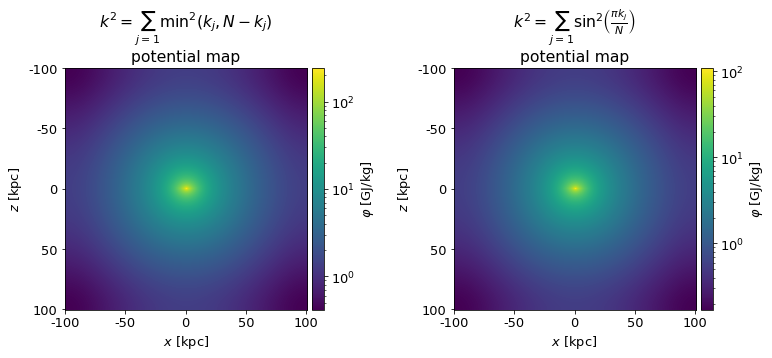

In [5]:
fig, ax1 = plt.subplots(1, 2, figsize=figsize)
ax1[0].set_title("$k^2 = \sum_{j=1} \mathrm{min}^2(k_j, N-k_j)$\npotential map")
im1 = ax1[0].imshow(abs(pot2[N2,:,:].real)/1e9, norm=LogNorm())
cbar1 = fig.colorbar(im1, ax=ax1[0], fraction=frac, pad=pad)
cbar1.set_label("$\\varphi$ [GJ/kg]")
ax1[0].set_xticks(x1)
ax1[0].set_xticklabels(x_l)
ax1[0].set_yticks(x1)
ax1[0].set_yticklabels(x_l)
ax1[0].set_xlabel("$x$ [kpc]")
ax1[0].set_ylabel("$z$ [kpc]")
ax1[1].set_title("$k^2 = \sum_{j=1} \sin^2 \left( \\frac{\pi k_j}{N} \\right)$\npotential map")
im2 = ax1[1].imshow(abs(pot[N2,:,:].real)/2e9, norm=LogNorm())
cbar2 = fig.colorbar(im2, ax=ax1[1], fraction=frac, pad=pad)
cbar2.set_label("$\\varphi$ [GJ/kg]")
ax1[1].set_xticks(x1)
ax1[1].set_xticklabels(x_l)
ax1[1].set_yticks(x1)
ax1[1].set_yticklabels(x_l)
ax1[1].set_xlabel("$x$ [kpc]")
ax1[1].set_ylabel("$z$ [kpc]");
plt.tight_layout()

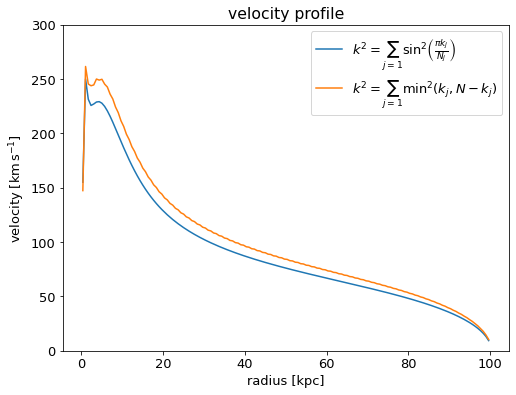

In [6]:
plt.figure(figsize=(8, 6))
plt.title("velocity profile")
plt.plot(r/kpc, v, label="$k^2 = \sum_{j=1} \sin^2 \left( \\frac{\pi k_j}{N_j} \\right)$")
plt.plot(r/kpc, v2, label="$k^2 = \sum_{j=1} \mathrm{min}^2(k_j, N-k_j)$")
plt.xlabel("radius [kpc]")
plt.ylabel("velocity [km$\,$s$^{-1}$]")
#plt.xlim(0,25)
#plt.ylim(0, max(v)*1.05)
plt.ylim(0, 300)
plt.legend()
#plt.show()
#plt.savefig("velocity_tlumeny.pdf", dpi=150)
#plt.close()

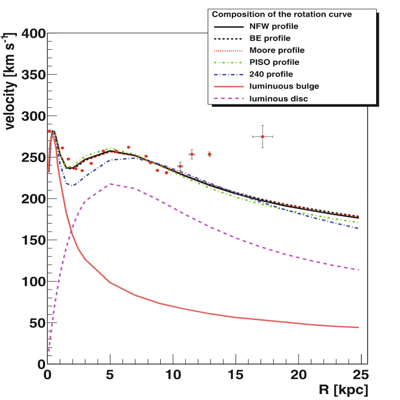

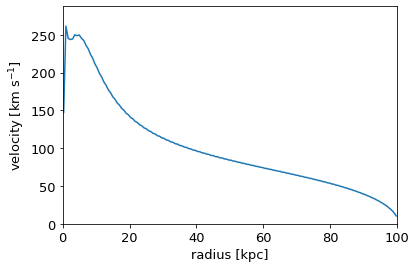

<Figure size 432x288 with 0 Axes>

In [7]:
plt.plot(r/kpc, v2)
plt.xlabel("radius [kpc]")
plt.ylabel("velocity [km s$^{-1}$]")
plt.xlim(0, size)
plt.ylim(0, max(v2)*1.1)

plt.figure()
from PIL import Image
img = Image.open("velocity_profile_weber.png")
img.resize((400, 400))

## Závěr

Jako správnější se mi zdá řešení b), ale přijde mi, že to má stále nějaké mouchy. V rámci tohoto řešení by však měly být splněny **periodické okrajové podmínky**. 

Profil rychlosti poblíž středu sedí poměrně dobře, avšak v krajních hodnotách jde pro mě z neznámých příčin příliš strmě k nule. A také mi stále nějak moc nesedí jednotky, navíc se hodnoty rychlosti mění s měnícím počtem bodů $N$ a i s měnící se velikostí (parametr size).